In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from tqdm import tqdm_notebook
from nltk.corpus import stopwords

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


reference


In [8]:
%%time
JIGSAW_PATH = "../input/"
train = pd.read_csv(os.path.join(JIGSAW_PATH,'train.csv'))
test = pd.read_csv(os.path.join(JIGSAW_PATH,'test.csv'))

CPU times: user 18.7 s, sys: 4.2 s, total: 22.9 s
Wall time: 22.9 s


In [9]:
train.head(10)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.000000,4,47
5,59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:50.865549+00,2,NaN,2006,rejected,0,0,0,0,0,0.009524,0,105
6,59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:52.451277+00,2,NaN,2006,rejected,0,0,0,0,0,0.220339,0,59
7,59863,0.000000,FFFFUUUUUUUUUUUUUUU,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:54.055221+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4
8,239575,0.000000,The ranchers seem motivated by mostly by greed...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 18:01:05.156229+00,6,NaN,26662,approved,0,0,0,0,0,0.000000,0,4
9,239576,0.000000,It was a great show. Not a combo I'd of expect...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 18:11:21.570460+00,6,239522.0,26650,approved,0,0,0,1,0,0.000000,0,4


In [10]:
test.head()

,id,comment_text
0,7000000,Jeff Sessions is another one of Trump's Orwell...
1,7000001,I actually inspected the infrastructure on Gra...
2,7000002,No it won't . That's just wishful thinking on ...
3,7000003,Instead of wringing our hands and nibbling the...
4,7000004,how many of you commenters have garbage piled ...


In [11]:
print("Train and test shape: {} {}".format(train.shape, test.shape))

Train and test shape: (1804874, 45) (97320, 2)


In [6]:
target 분포

SyntaxError: invalid syntax (<ipython-input-6-640d8e4740e7>, line 1)

target 분포

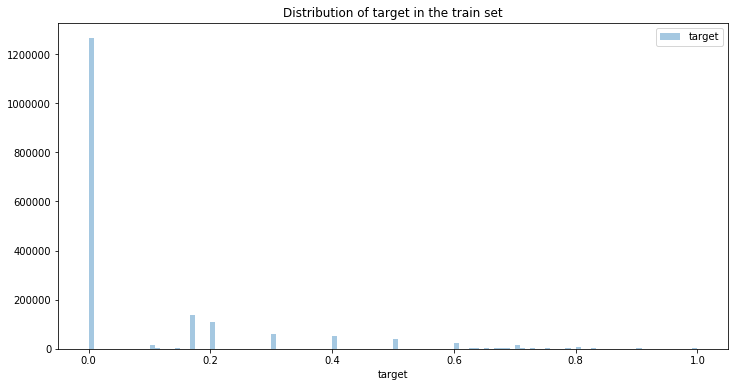

In [13]:

plt.figure(figsize=(12,6))
plt.title("Distribution of target in the train set")
sns.distplot(train['target'],kde=False,hist=True, bins=120, label='target')
plt.legend(); plt.show()

comment 길이 
1000 length에서 peak / xmdnl

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


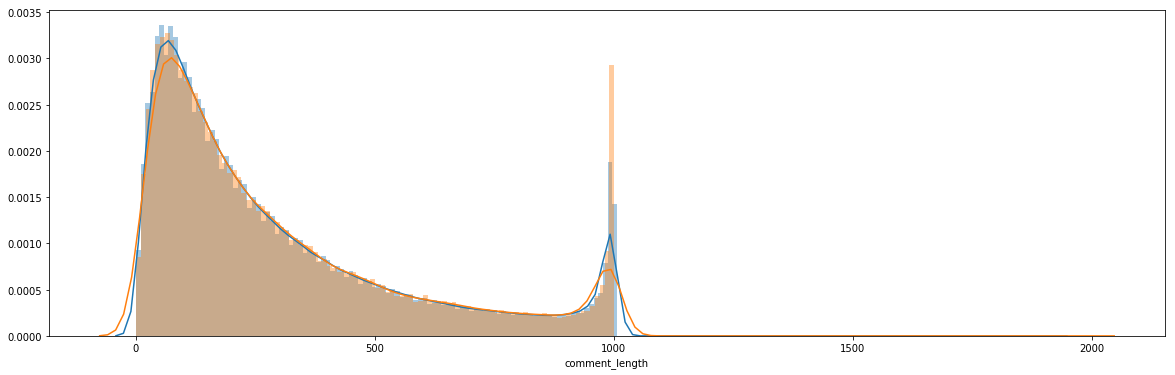

In [14]:
train['comment_length'] = train['comment_text'].apply(lambda x : len(x))
test['comment_length'] = test['comment_text'].apply(lambda x : len(x))
train['word_count'] = train['comment_text'].apply(lambda x : len(x.split(' ')))
test['word_count'] = test['comment_text'].apply(lambda x : len(x.split(' ')))
bin_size = max(train['comment_length'].max(), test['comment_length'].max())//10

plt.figure(figsize=(20, 6))
sns.distplot(train['comment_length'], bins=bin_size)  
sns.distplot(test['comment_length'], bins=bin_size)  
plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


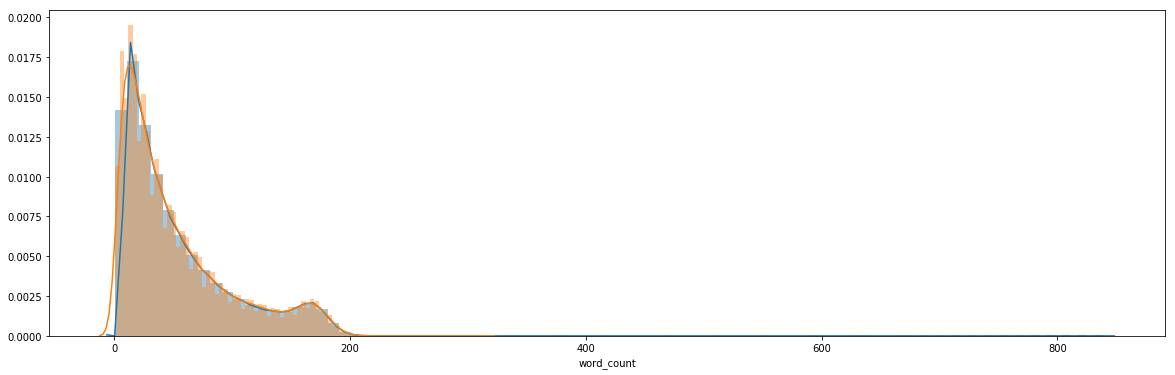

In [15]:
bin_size = max(train['word_count'].max(), test['word_count'].max())//10
plt.figure(figsize=(20, 6))
sns.distplot(train['word_count'], bins=bin_size)
sns.distplot(test['word_count'], bins=bin_size)
plt.show()

In [ ]:
* comment 대부분은 200단어 미만 
* 학습 / 테스트 셋 비슷한 분포를 가짐

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


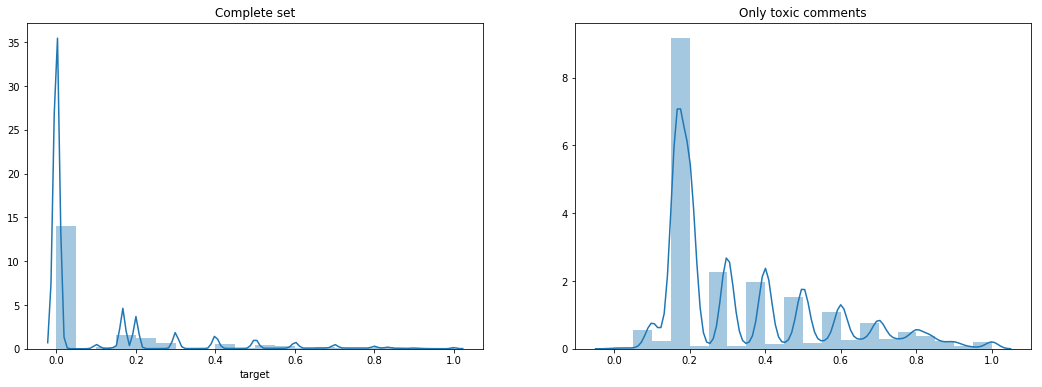

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sns.distplot(train['target'], bins=20, ax=ax1).set_title("Complete set")
sns.distplot(train[train['target'] > 0]['target'].values, bins=20, ax=ax2).set_title("Only toxic comments")
plt.show()

In [ ]:
comment 대부분은 0.2 (높지 않음)

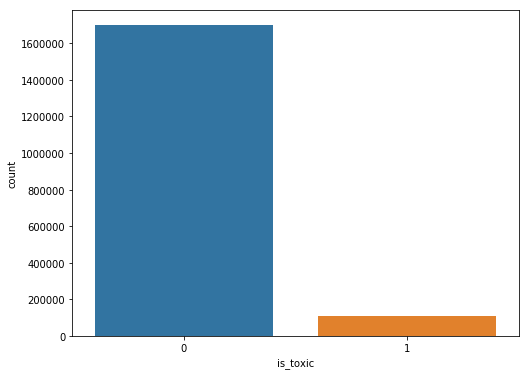

In [17]:
train['is_toxic'] = train['target'].apply(lambda x : 1 if (x > 0.5) else 0)
plt.figure(figsize=(8, 6))
sns.countplot(train['is_toxic'])
plt.show()

In [ ]:
0.5 기준으로 나눴을 때 
https://www.kaggle.com/dimitreoliveira/toxicity-bias-extensive-eda-and-bi-lstm

In [ ]:
어떤 identity가 함께 언급하는지 확인 (correlation)
얼마나 자주 언급되는지 (frequency)

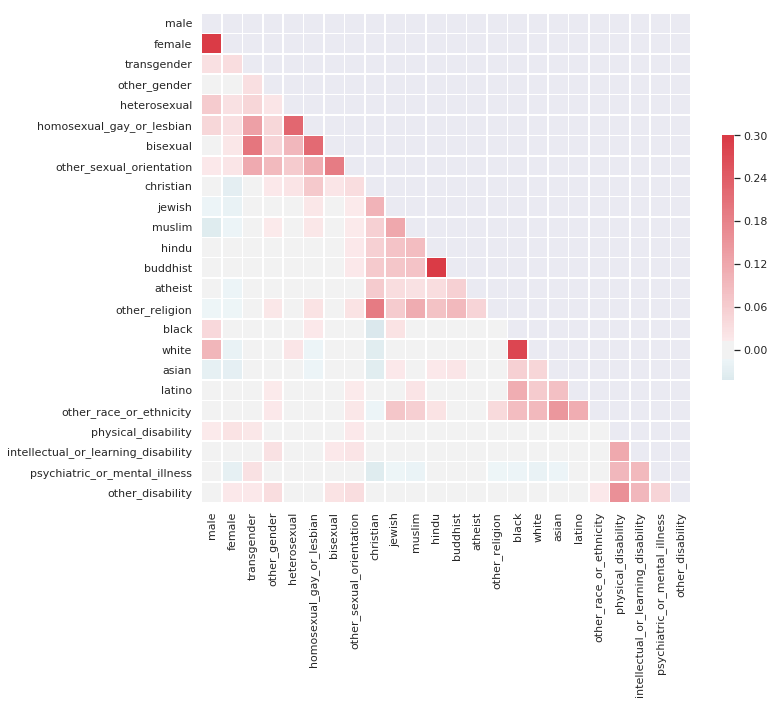

In [30]:
identities = ['male','female','transgender','other_gender','heterosexual','homosexual_gay_or_lesbian',
              'bisexual','other_sexual_orientation','christian','jewish','muslim','hindu','buddhist',
              'atheist','other_religion','black','white','asian','latino','other_race_or_ethnicity',
              'physical_disability','intellectual_or_learning_disability','psychiatric_or_mental_illness',
              'other_disability']

# to count the number of days from the first comment, we take our labeled data and convert the created date column
comments_with_date_df = train.loc[:, ['created_date', 'target','comment_text'] + identities].dropna()


# Compute the correlation matrix
corr = comments_with_date_df[identities].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
sns.set(font_scale = 1)
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



In [ ]:
대각선에 붉은색 ( 집단간의 correlation이 강하다)
예를들어 male 언급되면 female도 언급되고, 사람들은 하나의 그룹과 다른 그룹사이에 돈쟁을 한다. 


